In [1]:
# Load the packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, roc_curve, auc, accuracy_score, roc_auc_score


# Data Integration and Cleaning
Merging datasets from four different data sources (games, players, plays, and tackles) into a comprehensive dataset, ensuring data quality and consistency.


In [2]:
# Load the dataset

games_df = pd.read_csv("/Users/ved/Downloads/nfl-big-data-bowl-2024/games.csv")
players_df = pd.read_csv("/Users/ved/Downloads/nfl-big-data-bowl-2024/players.csv")
plays_df = pd.read_csv("/Users/ved/Downloads/nfl-big-data-bowl-2024/plays.csv")
tackles_df = pd.read_csv("/Users/ved/Downloads/nfl-big-data-bowl-2024/tackles.csv")

In [3]:
#preview the datasets
games_df.head(5), players_df.head(5), plays_df.head(5), tackles_df.head(5)

(       gameId  season  week    gameDate gameTimeEastern homeTeamAbbr  \
 0  2022090800    2022     1  09/08/2022        20:20:00           LA   
 1  2022091100    2022     1  09/11/2022        13:00:00          ATL   
 2  2022091101    2022     1  09/11/2022        13:00:00          CAR   
 3  2022091102    2022     1  09/11/2022        13:00:00          CHI   
 4  2022091103    2022     1  09/11/2022        13:00:00          CIN   
 
   visitorTeamAbbr  homeFinalScore  visitorFinalScore  
 0             BUF              10                 31  
 1              NO              26                 27  
 2             CLE              24                 26  
 3              SF              19                 10  
 4             PIT              20                 23  ,
    nflId height  weight   birthDate     collegeName position     displayName
 0  25511    6-4     225  1977-08-03        Michigan       QB       Tom Brady
 1  29550    6-4     328  1982-01-22        Arkansas        T    Ja

**Insights from datasets:**
* Players data: include players’ heights, weights, and position may 
* Play data: column ‘down’ and 'yardsToGo’ provide crucial information about the ongoing play.

In [4]:
tackles_df.describe()

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle
count,1.742600e+04,17426.000000,17426.000000,17426.000000,17426.000000,17426.000000,17426.000000
mean,2.022099e+09,1982.974578,47602.719442,0.569207,0.315276,0.005681,0.119936
std,5.978775e+03,1170.990596,4846.585868,0.495201,0.464639,0.075161,0.324896
min,2.022091e+09,54.000000,33131.000000,0.000000,0.000000,0.000000,0.000000
25%,2.022093e+09,952.000000,43797.000000,0.000000,0.000000,0.000000,0.000000
50%,2.022101e+09,1991.000000,46669.000000,1.000000,0.000000,0.000000,0.000000
75%,2.022102e+09,2981.750000,52546.000000,1.000000,1.000000,0.000000,0.000000
max,2.022111e+09,5096.000000,55241.000000,1.000000,1.000000,1.000000,1.000000


From the above table, we can see that the success tackle rate is around 56.9%.

# Exploratory Data Analysis
To understand the factors that might influence the success tackle rate, we would further perform a more detailed analysis by considering various aspects of the data.

First, I would start with merging the four datasets together using 'nflId', 'gameId', and 'playId'.

In [5]:
# Merge tackles data with player data
combined_df_1 = pd.merge(tackles_df, players_df, on = 'nflId')

# Then merge with play data
combined_df_2 = pd.merge(combined_df_1, plays_df, on = ['gameId', 'playId'])

# Further merge with games data
data = pd.merge(combined_df_2, games_df, on = 'gameId')

data

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle,height,weight,birthDate,...,foulNFLId1,foulNFLId2,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,101,42816,1,0,0,0,5-11,184,1991-08-29,...,NaN,NaN,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
1,2022090800,1102,42816,1,0,0,0,5-11,184,1991-08-29,...,NaN,NaN,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
2,2022090800,1102,52492,0,0,0,1,6-5,252,1998-08-25,...,NaN,NaN,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
3,2022090800,2043,42816,1,0,0,0,5-11,184,1991-08-29,...,NaN,NaN,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
4,2022090800,2527,42816,1,0,0,0,5-11,184,1991-08-29,...,NaN,NaN,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17421,2022091808,2970,54505,1,0,0,0,6-4,265,NaN,...,NaN,NaN,2022,2,09/18/2022,16:05:00,SF,SEA,27,7
17422,2022091808,3335,54505,1,0,0,0,6-4,265,NaN,...,NaN,NaN,2022,2,09/18/2022,16:05:00,SF,SEA,27,7
17423,2022091808,544,54574,1,0,1,0,6-1,198,NaN,...,NaN,NaN,2022,2,09/18/2022,16:05:00,SF,SEA,27,7
17424,2022091808,631,54574,1,0,0,0,6-1,198,NaN,...,NaN,NaN,2022,2,09/18/2022,16:05:00,SF,SEA,27,7


In [6]:
# Convert height to numerical numbers
def height_to_inches(height_str):
    if isinstance(height_str, str):
        parts = height_str.split('-')
        if len(parts) == 2:
            feet, inches = int(parts[0]), int(parts[1])
            return feet * 12 + inches
    return height_str  # if not string, return as is

# Apply the conversion to the 'height' column
data['height'] = data['height'].apply(height_to_inches)

In [7]:
data.describe()

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle,height,weight,ballCarrierId,...,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulNFLId1,foulNFLId2,season,week,homeFinalScore,visitorFinalScore
count,1.742600e+04,17426.000000,17426.000000,17426.000000,17426.000000,17426.000000,17426.000000,17426.000000,17426.000000,17426.000000,...,17426.000000,17426.000000,17426.000000,17424.000000,761.000000,31.000000,17426.0,17426.000000,17426.000000,17426.000000
mean,2.022099e+09,1982.974578,47602.719442,0.569207,0.315276,0.005681,0.119936,73.486859,232.930391,48188.776770,...,-0.000067,0.000067,2.215160,0.242920,47765.601840,49575.258065,2022.0,4.874670,22.704178,21.055664
std,5.978775e+03,1170.990596,4846.585868,0.495201,0.464639,0.075161,0.324896,2.190753,39.927658,4606.422151,...,0.034437,0.034437,1.585774,1.136264,4987.646861,3570.559657,0.0,2.561432,8.580195,9.530385
min,2.022091e+09,54.000000,33131.000000,0.000000,0.000000,0.000000,0.000000,68.000000,170.000000,25511.000000,...,-0.521181,-0.410824,-2.366872,-9.986150,33107.000000,43586.000000,2022.0,1.000000,3.000000,0.000000
25%,2.022093e+09,952.000000,43797.000000,0.000000,0.000000,0.000000,0.000000,72.000000,200.000000,44874.000000,...,-0.010758,-0.010872,1.046297,-0.445271,43503.000000,46527.000000,2022.0,3.000000,17.000000,15.000000
50%,2.022101e+09,1991.000000,46669.000000,1.000000,0.000000,0.000000,0.000000,73.000000,227.000000,47807.000000,...,0.000007,-0.000007,1.992672,0.063363,47791.000000,47996.000000,2022.0,5.000000,22.000000,20.000000
75%,2.022102e+09,2981.750000,52546.000000,1.000000,1.000000,0.000000,0.000000,75.000000,252.000000,52754.750000,...,0.010872,0.010758,3.360313,0.818275,53063.000000,53046.000000,2022.0,7.000000,27.000000,27.000000
max,2.022111e+09,5096.000000,55241.000000,1.000000,1.000000,1.000000,1.000000,80.000000,379.000000,55158.000000,...,0.410824,0.521181,6.556614,7.130048,55157.000000,54650.000000,2022.0,9.000000,49.000000,48.000000


Investigate the distribution of tackles across various attributes and identify patterns and correlations. Techniques like heatmaps and histograms are used for this analysis.


## 1. Correlation Matrix Heatmap
I started with looking at the distribution of tackles across different player attributes, play characteristics, and game context:
* player attributes (ex: height, weight, position)
* play characteristics (ex: down, yards to go)
* game context (ex: score, quarter, assist, forced Fumble, pff_missedTackle)

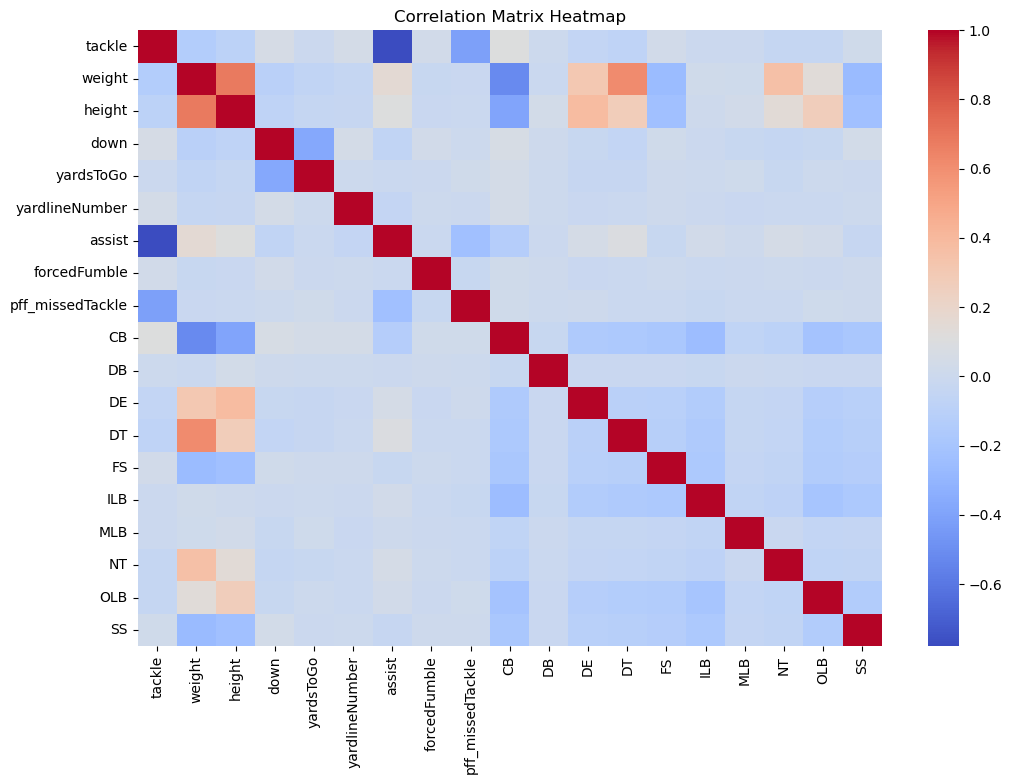

In [8]:
# Selecting relevant features for analysis
features = ['tackle', 'weight', 'height', 'down', 'position', 'yardsToGo', 'yardlineNumber', 'assist', 'forcedFumble', 'pff_missedTackle']
eda_df = data[features]

# Convert categorical variables to dummy variables
dummy_columns = pd.get_dummies(eda_df['position'])
eda_df = pd.concat([eda_df, dummy_columns], axis=1)

# Drop the original 'position' column as it's now represented by dummies
eda_df.drop('position', axis=1, inplace=True)

# Calculate the correlation matrix
correlation_matrix = eda_df.corr()

# Generate a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

The heatmap above illustrates the correlation coefficients between different features in our dataset. Darker red squares indicate a stronger positive correlation, while darker blue squares signify a stronger negative correlation. The diagonal line shows a perfect positive correlation (correlation coefficient of 1) where each feature correlates with itself.

Notably, the features `assist` and `forcedFumble` exhibit a positive correlation with `tackle`, suggesting a relationship between these variables and successful tackles. The player positions, represented as dummy variables, also provide interesting insights; for example, `position_CB` correlates with `pff_missedTackle`, which may reflect the involvement of cornerbacks in plays with missed tackles.

Variables with minimal correlation (light-colored squares) will be considered carefully for their relevance in predictive modeling. It's important to remember that correlation does not equal causation, and this heatmap solely reflects linear relationships.

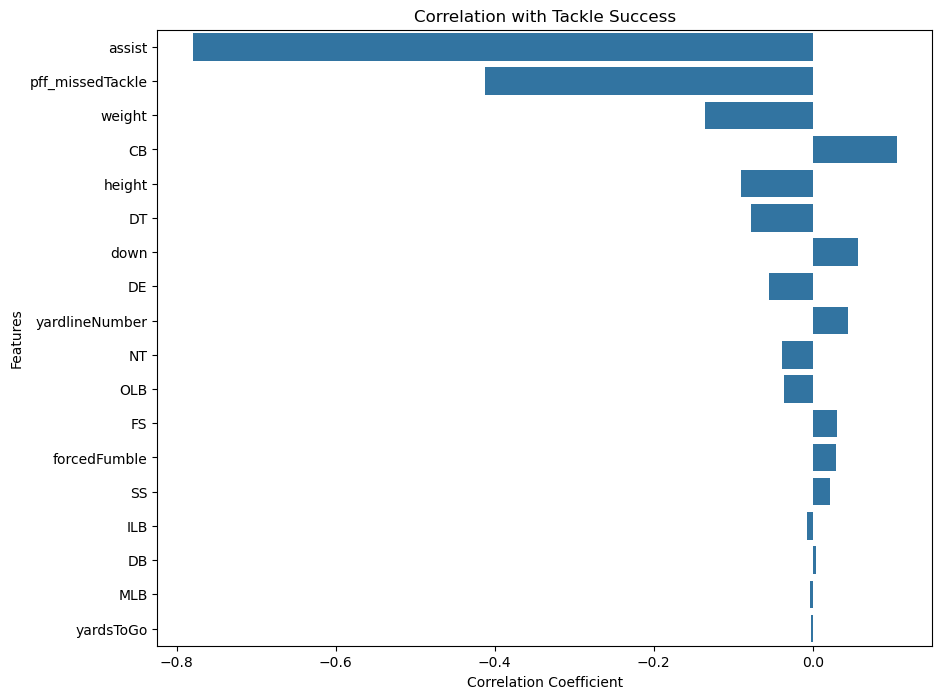

In [9]:
# Calculate the correlation matrix
correlation_matrix = eda_df.corr()

# Sort the correlations with 'tackle'
sorted_correlation_with_tackle = correlation_matrix['tackle'].sort_values(key = abs, ascending = False)

# Exclude the 'tackle' variable itself to avoid a self-correlation of 1
sorted_correlation_with_tackle = sorted_correlation_with_tackle[sorted_correlation_with_tackle.index != 'tackle']

# Now, visualize this sorted correlation with a bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_correlation_with_tackle.values, y=sorted_correlation_with_tackle.index)
plt.title('Correlation with Tackle Success')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

## 2. Distribution of Tackles by Player
Next, I wanted to look at the performance and frequency of tackles by each player.


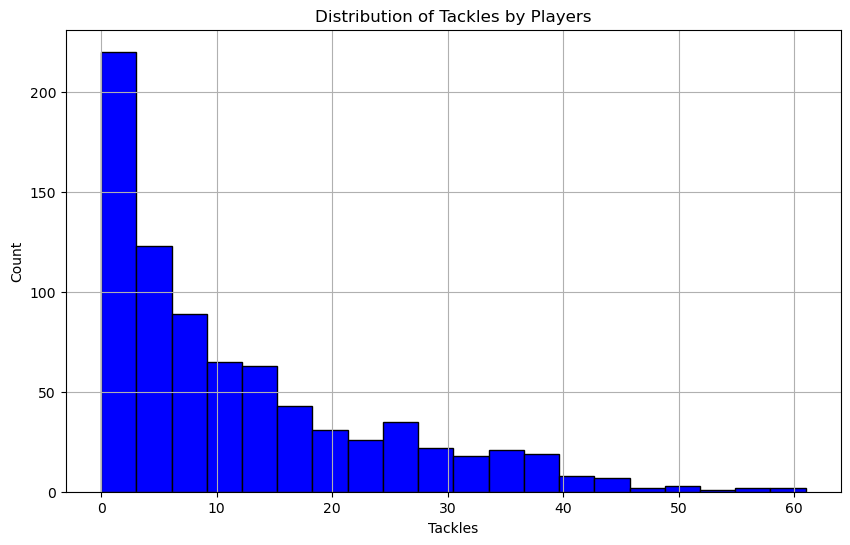

In [10]:
tackle_players = data.groupby(['nflId'])['tackle'].agg('sum')

# Creating a DataFrame by passing a dictionary
frame = {'nfl_id': tackle_players.index, 'tackles': tackle_players}
agg_data = pd.DataFrame(frame).reset_index()
agg_data = agg_data.drop(columns=['nfl_id'], axis=1)

# Plotting using matplotlib
plt.figure(figsize=(10, 6))
plt.hist(agg_data['tackles'], bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Tackles by Players')
plt.xlabel('Tackles')
plt.ylabel('Count')
plt.grid(True)
plt.show()

## 3. Distribution of tackles by player height and weight
Then, I started looking at players’ heights and weights to find patterns related to the occurrence of successful tackles.

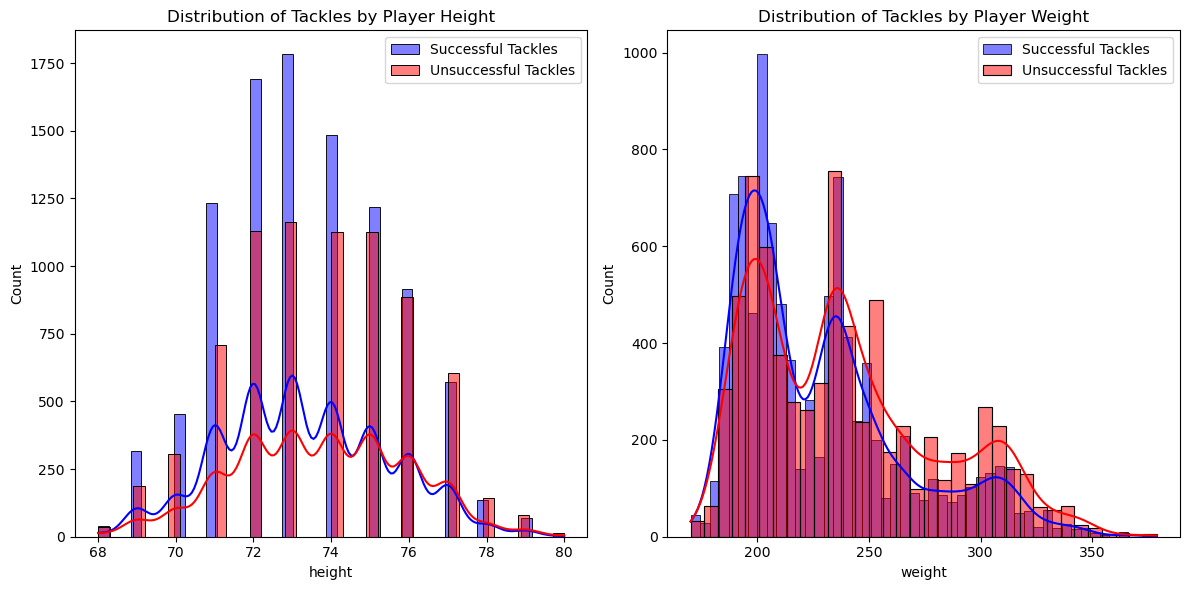

In [11]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data[data['tackle'] == 1]['height'], kde=True, color='blue', label='Successful Tackles')
sns.histplot(data[data['tackle'] == 0]['height'], kde=True, color='red', label='Unsuccessful Tackles')
plt.title('Distribution of Tackles by Player Height')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(data[data['tackle'] == 1]['weight'], kde=True, color='blue', label='Successful Tackles')
sns.histplot(data[data['tackle'] == 0]['weight'], kde=True, color='red', label='Unsuccessful Tackles')
plt.title('Distribution of Tackles by Player Weight')
plt.legend()

plt.tight_layout()
plt.show()

# Feature Engineering

After EDA, I created new features like player BMI and interaction terms to capture complex relationships within the data.


In [12]:
# Feature 1: Interaction term between 'down' and 'yardsToGo'
data['down_yards_interaction'] = data['down'] * data['yardsToGo']

# Feature 2: Body Mass Index (BMI)
def calculate_bmi(weight, height_in_inches):
    # BMI formula: 703 * weight in pounds / (height in inches)^2
    return 703 * weight / (height_in_inches ** 2)
data['player_bmi'] = data.apply(lambda row: calculate_bmi(row['weight'], row['height']), axis=1)

feature_data = data[['down_yards_interaction', 'player_bmi', 'quarter', 'assist', 'forcedFumble', 'tackle']]
feature_data.head(10)

,down_yards_interaction,player_bmi,quarter,assist,forcedFumble,tackle
0,10,25.659988,1,0,0,1
1,12,25.659988,2,0,0,1
2,12,29.879575,2,0,0,0
3,10,25.659988,3,0,0,1
4,20,25.659988,3,0,0,1
5,10,25.659988,1,0,0,1
6,10,25.659988,3,1,0,0
7,10,28.456738,3,0,0,1
8,10,40.164474,3,0,0,0
9,10,25.659988,4,1,0,0


# Split the data

In [13]:
# Splitting the dataset into training, validation, and test sets
train, test = train_test_split(feature_data, test_size=0.4, random_state=42)
val, test = train_test_split(test, test_size=0.5, random_state=42)

# Apply get_dummies to each split separately
X_train = pd.get_dummies(train.drop('tackle', axis=1), drop_first=True)
y_train = train['tackle']

X_val = pd.get_dummies(val.drop('tackle', axis=1), drop_first=True)
y_val = val['tackle']

X_test = pd.get_dummies(test.drop('tackle', axis=1), drop_first=True)
y_test = test['tackle']

# Standardize the numerical features
# Note: Only standardize numerical columns. For simplicity, I'm assuming all columns are now either numerical or one-hot encoded
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Now, the dataset should be ready for training and evaluating a model

## 1. Support Vector Machines (SVM):

In [14]:
import numpy as np
import matplotlib.pyplot as plt

class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        self.tree = self._grow_tree(X, y)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _best_split(self, X, y):
        m = y.size
        if m <= self.min_samples_split:
            return None, None
        num_parent = [np.sum(y == c) for c in range(self.n_classes)]
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None
        for idx in range(self.n_features):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes
            num_right = num_parent.copy()
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes)
                )
                gini = (i * gini_left + (m - i) * gini_right) / m
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(
            num_samples=y.size,
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )
        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _predict(self, inputs):
        node = self.tree
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

class Node:
    def __init__(self, num_samples, num_samples_per_class, predicted_class):
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_samples=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_samples = n_samples
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            if self.n_samples is None:
                X_subset, y_subset = X, y
            else:
                indices = np.random.choice(len(X), size=self.n_samples, replace=True)
                X_subset, y_subset = X[indices], y[indices]
            tree.fit(X_subset, y_subset)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.zeros((len(X), len(self.trees)))
        for i, tree in enumerate(self.trees):
            predictions[:, i] = tree.predict(X)
        predictions = np.round(predictions).astype(int)  # Round predictions to the nearest integer
        return np.array([np.argmax(np.bincount(predictions[i])) for i in range(len(X))])

# Load and prepare your data (X_train, y_train, X_test, y_test)
feature_data = data[['down_yards_interaction', 'player_bmi', 'quarter', 'assist', 'forcedFumble', 'tackle']]

# Splitting the dataset into training and test sets
train, test = train_test_split(feature_data, test_size=0.4, random_state=42)

# Apply get_dummies to each split separately
X_train = pd.get_dummies(train.drop('tackle', axis=1), drop_first=True)
y_train = train['tackle'].astype(int)  # Convert y_train to integer

X_test = pd.get_dummies(test.drop('tackle', axis=1), drop_first=True)
y_test = test['tackle'].astype(int)  # Convert y_test to integer

# Standardize the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create an instance of the RandomForest classifier
rf_clf = RandomForest(n_trees=100, max_depth=10, min_samples_split=2, n_samples=None)

# Train the model
rf_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_clf.predict(X_test)

# Evaluate the model's performance
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy}")

# Compute the feature importances
feature_importances = np.zeros(X_train.shape[1])
for tree in rf_clf.trees:
    feature_importances += np.zeros(X_train.shape[1])
    node = tree.tree
    while node.left:
        feature_importances[node.feature_index] += node.num_samples
        node = node.left if np.sum(node.left.num_samples) > np.sum(node.right.num_samples) else node.right
feature_importances /= len(rf_clf.trees)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

y_train shape: (10456,)
y_train contents: [1. 0. 1. ... 0. 1. 0.]
Accuracy: 0.5694404591104735


NameError: name 'svc' is not defined

## 2. Logistic Regression

In [ ]:
logistic_model = LogisticRegression(fit_intercept=True, max_iter=1000).fit(X_train,y_train)

logistic_pred_test = logistic_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

fpr, tpr, threshold = roc_curve(y_test, logistic_pred_test[:,1])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
confusion_matrix(y_test, (logistic_pred_test[:,1] > 0.5))

* Accuracy: 0.878/ AUC: 0.87
* Given our binary outcome (successful or unsuccessful tackle), I adopt logistic regression to predict the probability of a tackle’s success based on our selected input features. An AUC of 0.87 shows a high level of model performance, with the model having a good measure of separability and being able to distinguish between success and failure tackles.

## 3. Random Forest Classifier

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        self.tree = self._grow_tree(X, y)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _best_split(self, X, y):
        m = y.size
        if m <= self.min_samples_split:
            return None, None
        num_parent = [np.sum(y == c) for c in range(self.n_classes)]
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None
        for idx in range(self.n_features):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes
            num_right = num_parent.copy()
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes)
                )
                gini = (i * gini_left + (m - i) * gini_right) / m
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(
            num_samples=y.size,
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )
        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _predict(self, inputs):
        node = self.tree
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

class Node:
    def __init__(self, num_samples, num_samples_per_class, predicted_class):
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_samples=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_samples = n_samples
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            if self.n_samples is None:
                X_subset, y_subset = X, y
            else:
                indices = np.random.choice(len(X), size=self.n_samples, replace=True)
                X_subset, y_subset = X[indices], y[indices]
            tree.fit(X_subset, y_subset)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.zeros((len(X), len(self.trees)))
        for i, tree in enumerate(self.trees):
            predictions[:, i] = tree.predict(X)
        predictions = np.round(predictions).astype(int)  # Round predictions to the nearest integer
        return np.array([np.argmax(np.bincount(predictions[i])) for i in range(len(X))])

# Load and prepare your data (X_train, y_train, X_test, y_test)
feature_data = data[['down_yards_interaction', 'player_bmi', 'quarter', 'assist', 'forcedFumble', 'tackle']]

# Splitting the dataset into training and test sets
train, test = train_test_split(feature_data, test_size=0.4, random_state=42)

# Apply get_dummies to each split separately
X_train = pd.get_dummies(train.drop('tackle', axis=1), drop_first=True)
y_train = train['tackle'].astype(int)  # Convert y_train to integer

X_test = pd.get_dummies(test.drop('tackle', axis=1), drop_first=True)
y_test = test['tackle'].astype(int)  # Convert y_test to integer

# Standardize the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create an instance of the RandomForest classifier
rf_clf = RandomForest(n_trees=100, max_depth=10, min_samples_split=2, n_samples=None)

# Train the model
rf_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_clf.predict(X_test)

# Evaluate the model's performance
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy}")

# Compute the feature importances
feature_importances = np.zeros(X_train.shape[1])
for tree in rf_clf.trees:
    feature_importances += np.zeros(X_train.shape[1])
    node = tree.tree
    while node.left:
        feature_importances[node.feature_index] += node.num_samples
        node = node.left if np.sum(node.left.num_samples) > np.sum(node.right.num_samples) else node.right
feature_importances /= len(rf_clf.trees)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

* Accuracy: 0.839/ AUC: 0.86
* The Random Forest classifier is renowned for its robustness and accuracy. By utilizing an ensemble of decision trees, the Random Forest model reduces the risk of overfitting, which is important given the complexity of the interactions within our feature set. The AUC is 0.86, indicating a high level of precision in classifying tackles.

* Feature Importance Analysis: ‘Assist’ had a significant importance score, implying that the involvement of additional players in a tackle is likely to complete a tackle. Moreover, the physical aspect - ‘Player_BMI’ also surfaced as a key predictor of tackle.

## 4. Decision Tree

In [ ]:
# function for printing a tree
import pydot
from io import StringIO
from IPython.display import Image
def print_tree(estimator, features, class_names=None, filled=True):
  tree = estimator
  names = features
  color = filled
  classn = class_names
  dot_data = StringIO()
  export_graphviz(estimator, out_file=dot_data,feature_names=features,class_names=classn, filled=filled)
  graph = pydot.graph_from_dot_data(dot_data.getvalue())
  return(graph)

In [ ]:
tackle_tree = DecisionTreeClassifier(min_samples_split=3,min_impurity_decrease=0.000001)
tackle_tree.fit(X_train, y_train)
graph, = print_tree(tackle_tree, features= train.drop(columns = ['tackle']).columns)
Image(graph.create_png())

In [ ]:
tackle_tree_preds = tackle_tree.predict_proba(X_val)

In [ ]:
fpr, tpr, threshold = roc_curve(val['tackle'], tackle_tree_preds[:,1])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Decision Trees presented a more modest accuracy of 80.5%. While lower than the other models, this still represents a significant predictive capability, especially considering the model's interpretability.

# Result

In [ ]:
# SVM
y_pred_svc = svc.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"SVM Model Accuracy: {accuracy_svc}")

# Logistic Regression
y_pred_logistic = logistic_model.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f"Logistic Regression Model Accuracy: {accuracy_logistic}")

# Random Forest
y_pred_rf = rf_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Model Accuracy: {accuracy_rf}")

# Decision Tree
y_pred_dt = tackle_tree.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Model Accuracy: {accuracy_dt}")
